# 2D UNet

## Environment Setup

In [1]:
import time
import random 
import requests
import numpy as np
import pandas as pd
import os

import keras
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, SpatialDropout2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

""" Settings for visuals"""
alpha = 0.75

Using TensorFlow backend.


## Gather Data

In [2]:
# File names to save training data
X_train_path = 'X_train.npy'
Y_train_path = 'Y_train.npy'

In [3]:
# Download training data from S3 bucket
# NOTE: You should only need to run this once. 

s3_url = 'https://s3.amazonaws.com/com.bsethwalker/cs109b/luna16/2d/'
if not (os.path.exists(X_train_path)):
    r = requests.get(s3_url+X_train_path, allow_redirects=True)
    open(X_train_path, 'wb').write(r.content)
     
if not os.path.exists(Y_train_path):
    r = requests.get(s3_url+Y_train_path, allow_redirects=True)
    open(Y_train_path, 'wb').write(r.content);

In [4]:
# Load full training set
X_train_full = np.load(X_train_path)
Y_train_full = np.load(Y_train_path)

#### Resize the images

In [5]:
# Images Dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # grayscale would be 1, 3 is RGB

In [6]:
# Resize the images to the defined sizes
X_train_resized = []
Y_train_resized = []

# Preprocess Images
for i in range(len(X_train_full)):
    X_train_resized.append(resize(X_train_full[i], 
                                  (IMG_WIDTH, IMG_HEIGHT),
                                  mode = 'constant', 
                                  preserve_range = True))
    
    Y_train_resized.append(resize(Y_train_full[i], 
                                  (IMG_WIDTH, IMG_HEIGHT),
                                  mode = 'constant', 
                                  preserve_range = True))

In [7]:
# Convert to numpy arrays 
X_train_full = np.array(X_train_resized)
Y_train_full = np.array(Y_train_resized)

# Free some memory
del X_train_resized, Y_train_resized

In [8]:
# Just make sure we have everything, and it's all the 
# expected number of dimensions.
print(len(X_train_full))  # = 888
print(X_train_full.shape) # = (888, 256, 256)
print(Y_train_full.shape) # = (888, 256, 256)

888
(888, 256, 256)
(888, 256, 256)


## Create Test and Training Data

#### Split into Test and Validation

In [9]:
# Split our training data into test/validation
VAL_SIZE = 75  # Size of validation set

N = X_train_full.shape[0]

# set seed for reproducible split
np.random.seed(42)

msk = np.random.choice(range(N), VAL_SIZE, replace = False)

X_train = X_train_full[[i for i in range(N) if i not in msk]]
Y_train = Y_train_full[[i for i in range(N) if i not in msk]]

X_val = X_train_full[msk]
Y_val = Y_train_full[msk]

print("There are %d training and %d valdiation records out of %d total." 
      % (X_train.shape[0], X_val.shape[0], N))

There are 813 training and 75 valdiation records out of 888 total.


In [10]:
# Free up memory
del X_train_full, Y_train_full

In [11]:
# Use expand_dims to add the channel dimension
X_train = np.expand_dims(X_train, axis=3)
Y_train = np.expand_dims(Y_train, axis=3)

X_val = np.expand_dims(X_val, axis=3)
Y_val = np.expand_dims(Y_val, axis=3)

In [12]:
# Make sure things are the correct dimensions.
print(Y_val.shape)   # = (75, 256, 256, 1)
print(X_train.shape) # = (813, 256, 256, 1)

(75, 256, 256, 1)
(813, 256, 256, 1)


## Load Model

In [16]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

In [17]:
model_file = 'unet_training.h5'
model = load_model(model_file, 
                   custom_objects={'dice_coef_loss': dice_coef_loss, 
                                       'dice_coef':      dice_coef})

## Approximate Bayesian Inference with Dropout

In [18]:
import keras.backend as K
from tqdm import tqdm
from skimage.color import hsv2rgb
from skimage.draw import circle_perimeter_aa
from seaborn import distplot
from skimage.filters import gaussian

In [41]:
# adapted from https://github.com/keras-team/keras/issues/9412

# We could build the model with dropout always on, but we didn't.
# Here, we create a new back-end function to run inference with it on
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output])


def predict_with_uncertainty(f, x, n_iter=1000):
    
    result = np.zeros((n_iter, *x.shape))
    
    for i in tqdm(range(n_iter)):
        result[i] = f((x[None],1))[0]
        
    return result


def prediction_mask(x_samples):

    n_samples = x_samples.shape[0]
    
    sample_means = np.mean(x_samples, axis=0)
    sample_stds = np.std(x_samples, axis=0)
    
    mask = np.zeros((*x_samples[0].shape[:2], 3))   
    mask[:,:,0] = 0
    mask[:,:,1] = np.clip(sample_means[...,0],0,1)
    mask[:,:,2] = np.clip(sample_means[...,0]-sample_stds[...,0]*sample_means[...,0],0,1)

    rgb_mask = hsv2rgb(mask)
    smooth_mask = gaussian(rgb_mask, 1, multichannel=True)
    
    return smooth_mask

In [21]:
def clip_and_normalize(data):
    '''
    Clips data taken as HU so that all points are between Air and Bone, inclusive.
    Normalizes the clipped data to between 0 and 1.
    '''
    clipped = np.clip(data, a_min=-1000, a_max=700)
    normd = (clipped + 1000) / 1700
    return np.clip(normd, a_min=0, a_max=1)

In [22]:
def detect_nodules(image, n_samples=1000):
    
    predictions = predict_with_uncertainty(f, image, n_iter=n_samples)
    
    # make image mask
    mask = prediction_mask(predictions)
    
    normd_image = clip_and_normalize(image)
    
    display_image = mask.copy()
    display_image[...,2] = np.max((mask[...,2], normd_image[...,0]), axis=0)
    
    # get data on most likely nodule
    pred_means = np.mean(predictions, axis=0) / n_samples
    highest_idx = np.unravel_index(np.argmax(pred_means), pred_means.shape)[:2]
    samples = predictions[:,highest_idx[0],highest_idx[1]]
    
    # draw indicator to most likely point
    rr, cc, val = circle_perimeter_aa(*highest_idx, int(predictions.shape[1]*0.1), shape=display_image.shape)
    display_image[rr,cc,0] = val
    
    return display_image, samples

In [69]:
def evaluate_sample(sample, ground_truth, suptitle=''):
    
    display_image, prob_samples = detect_nodules(sample, n_samples=1000)
    
    fig = plt.figure(figsize=(15,5))
    
    plt.subplot(131)
    plt.imshow(clip_and_normalize(ground_truth).reshape(256,256), cmap='viridis')
    plt.title('Ground Truth')
    plt.grid(False)
    plt.subplot(132)
    plt.grid(False)
    plt.imshow(display_image)
    plt.title('Possible Nodules')
    plt.grid(False);
    plt.subplot(133)
    plt.hist(prob_samples, bins=10)
    plt.title('Detections on Most Likely Region')
    plt.suptitle(suptitle);

    plt.show();

100%|██████████| 1000/1000 [00:12<00:00, 82.27it/s]


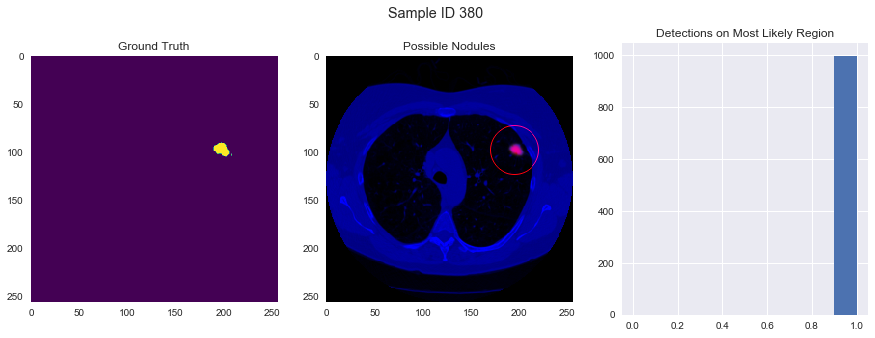

In [71]:
evaluate_sample(X_train[380], Y_train[380], suptitle='Sample ID {}'.format(380))

100%|██████████| 1000/1000 [00:12<00:00, 82.29it/s]


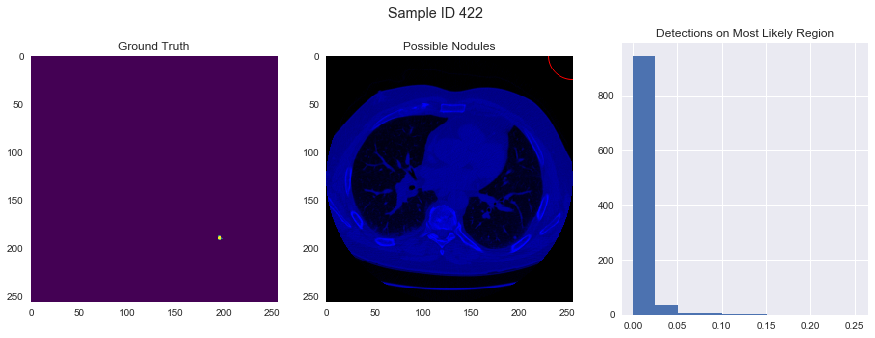

100%|██████████| 1000/1000 [00:12<00:00, 79.50it/s]


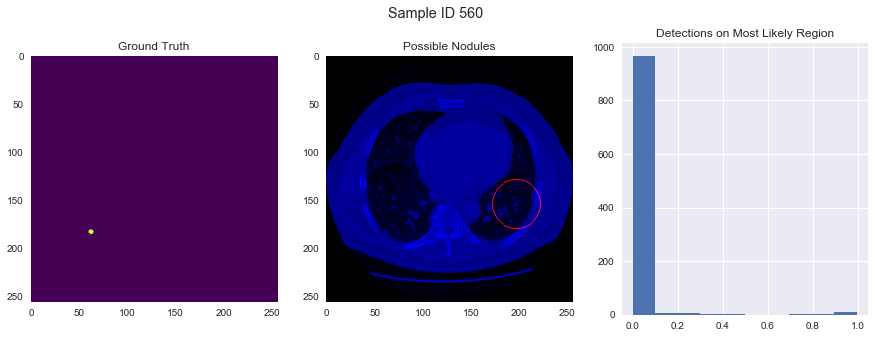

100%|██████████| 1000/1000 [00:13<00:00, 76.39it/s]


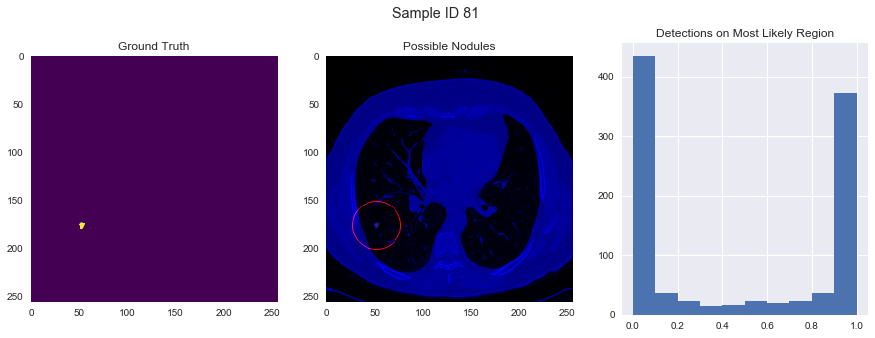

100%|██████████| 1000/1000 [00:13<00:00, 76.71it/s]


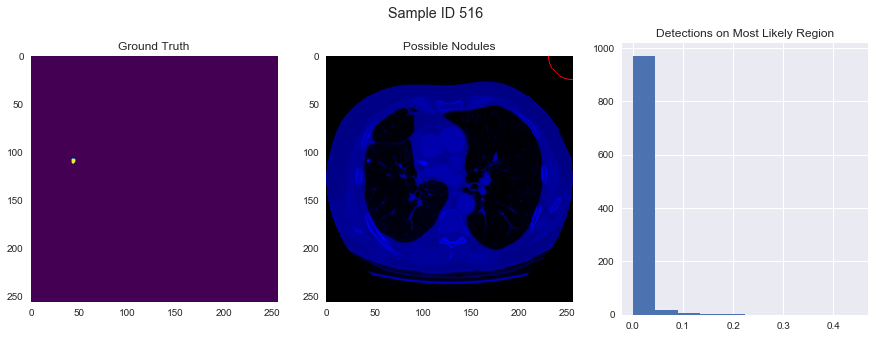

100%|██████████| 1000/1000 [00:13<00:00, 76.21it/s]


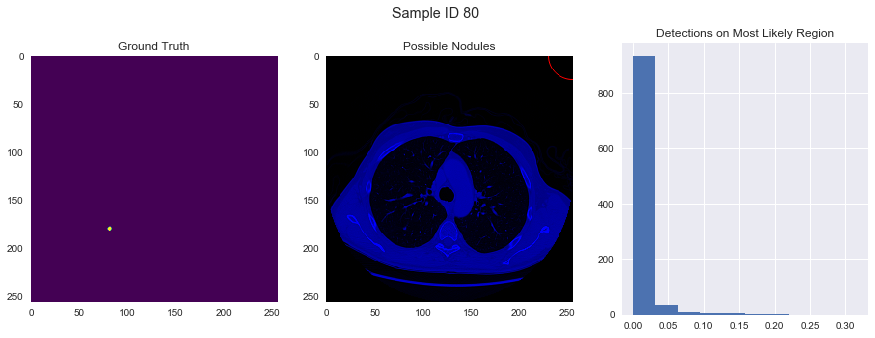

100%|██████████| 1000/1000 [00:13<00:00, 76.69it/s]


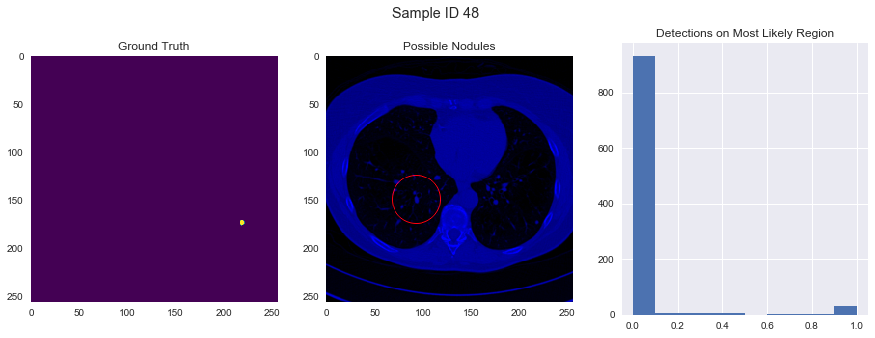

100%|██████████| 1000/1000 [00:13<00:00, 76.53it/s]


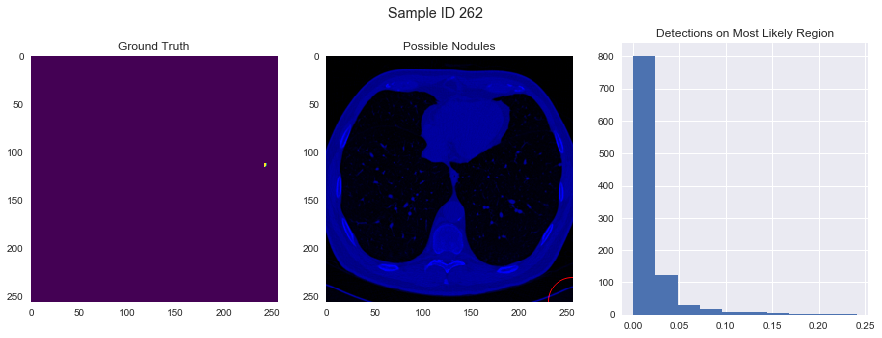

100%|██████████| 1000/1000 [00:13<00:00, 76.74it/s]


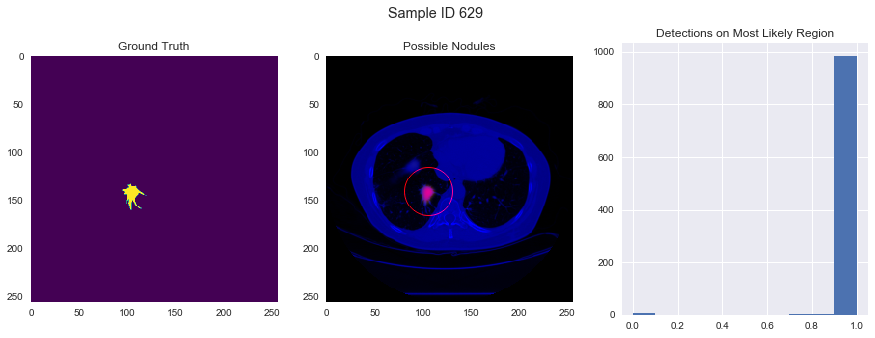

100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


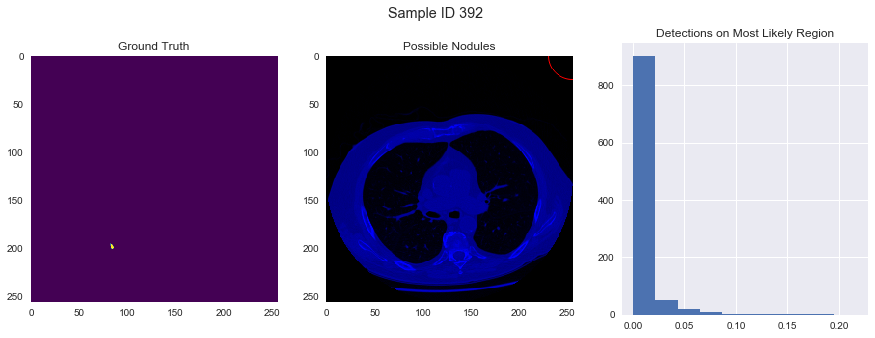

100%|██████████| 1000/1000 [00:13<00:00, 76.42it/s]


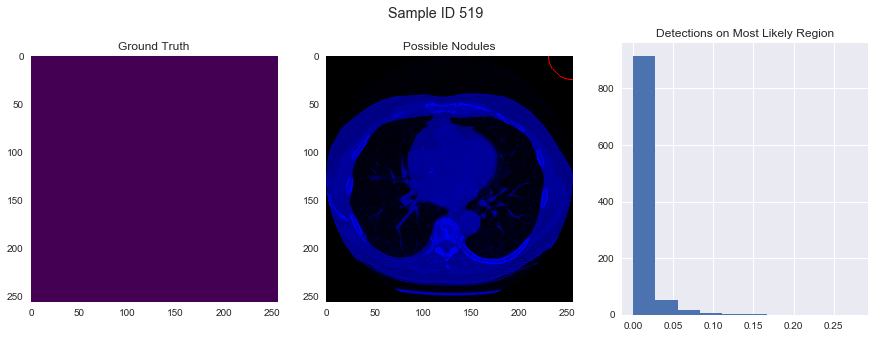

100%|██████████| 1000/1000 [00:13<00:00, 76.60it/s]


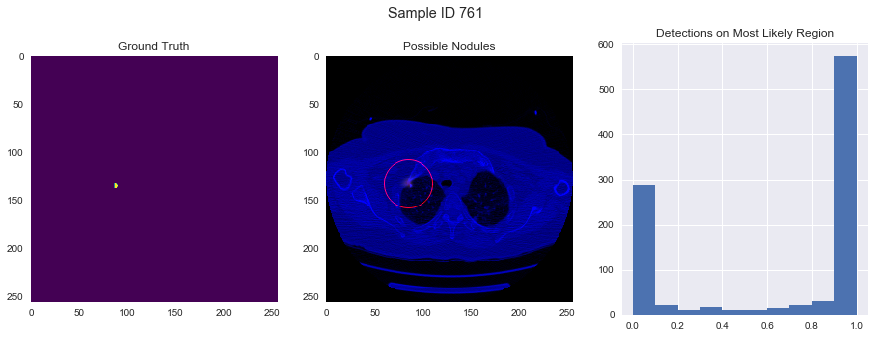

100%|██████████| 1000/1000 [00:13<00:00, 76.76it/s]


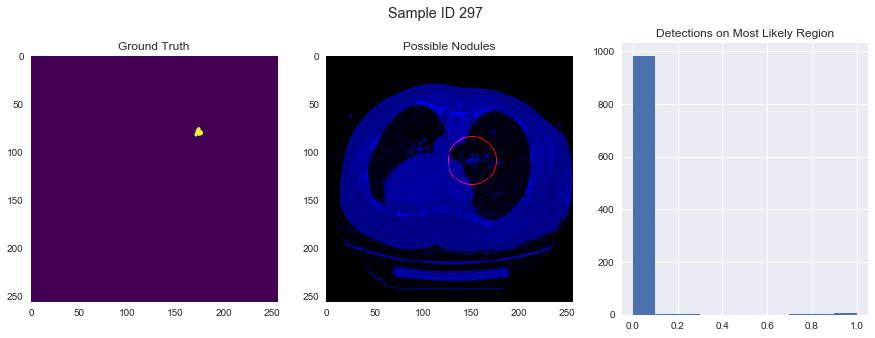

100%|██████████| 1000/1000 [00:13<00:00, 76.31it/s]


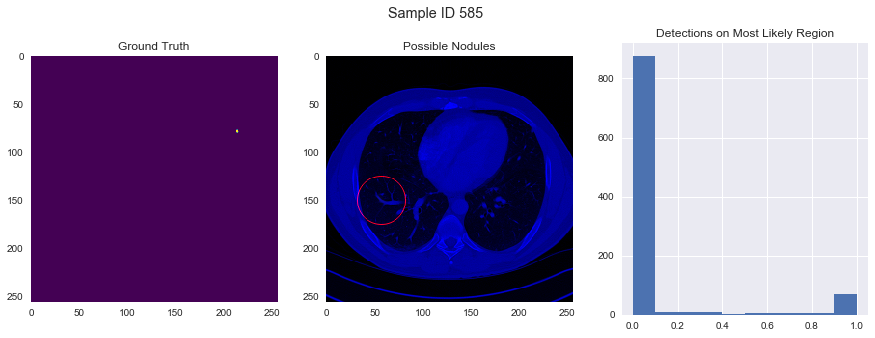

100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


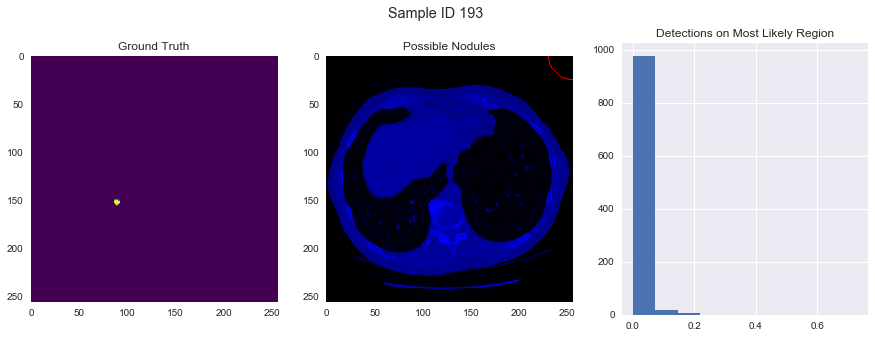

100%|██████████| 1000/1000 [00:13<00:00, 76.56it/s]


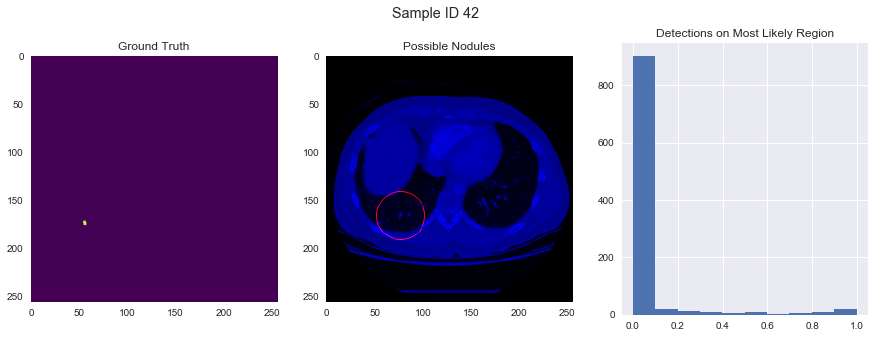

100%|██████████| 1000/1000 [00:13<00:00, 76.50it/s]


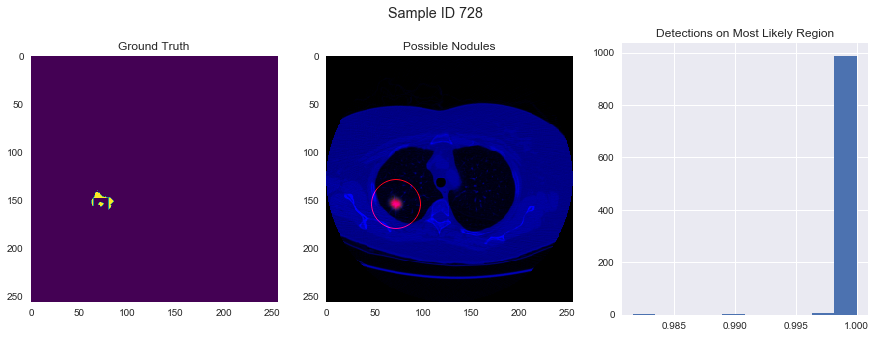

100%|██████████| 1000/1000 [00:13<00:00, 76.42it/s]


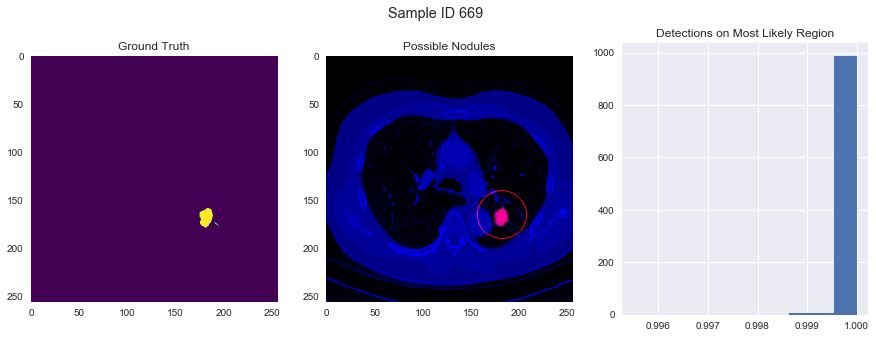

100%|██████████| 1000/1000 [00:13<00:00, 76.40it/s]


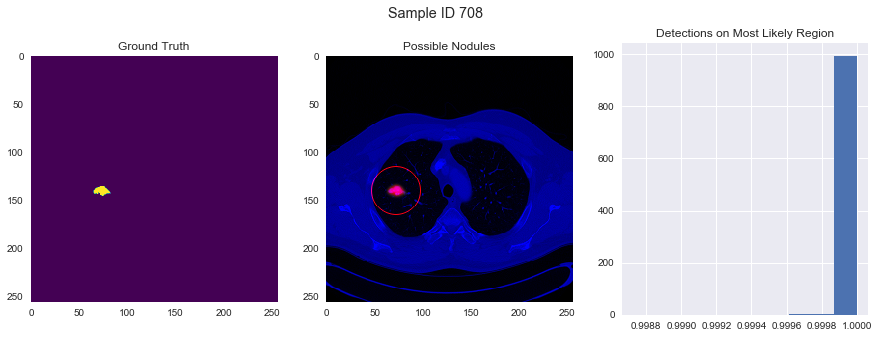

100%|██████████| 1000/1000 [00:13<00:00, 76.28it/s]


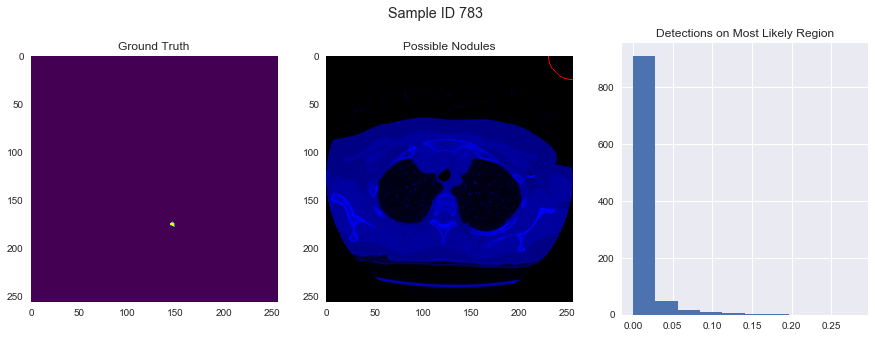

100%|██████████| 1000/1000 [00:13<00:00, 76.47it/s]


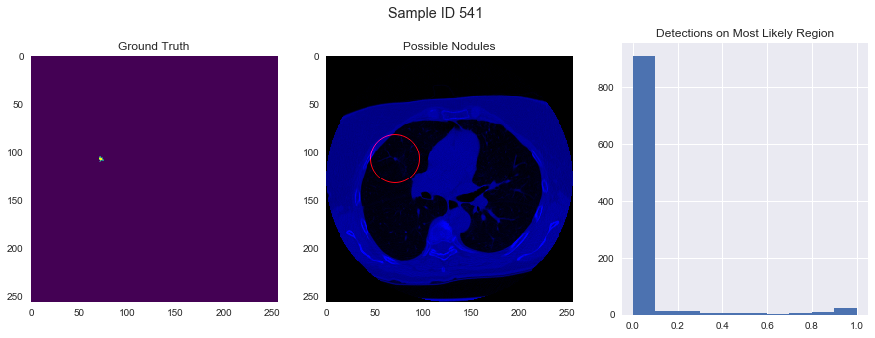

100%|██████████| 1000/1000 [00:13<00:00, 76.53it/s]


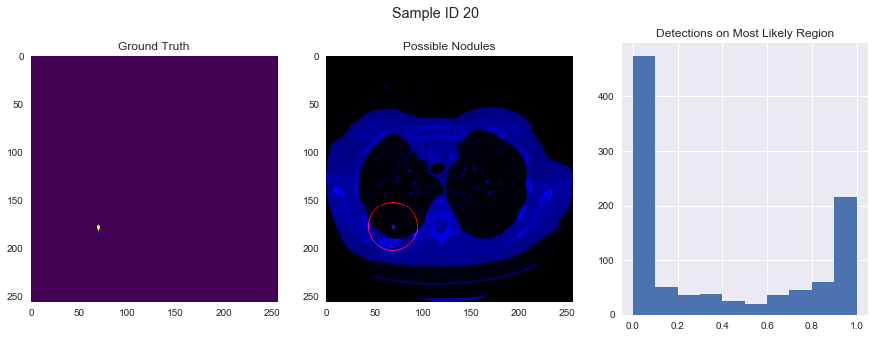

100%|██████████| 1000/1000 [00:13<00:00, 76.59it/s]


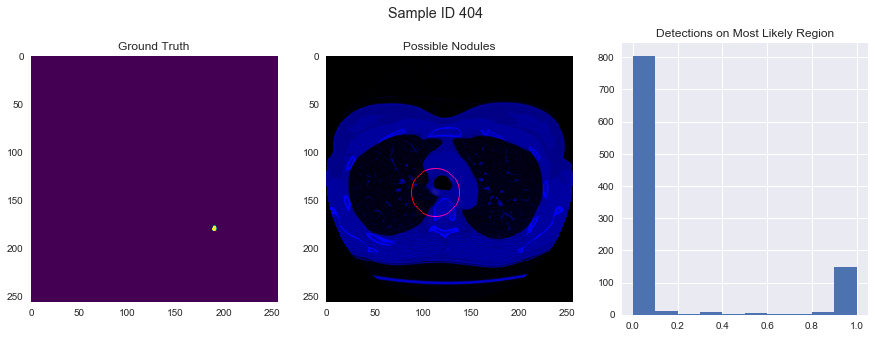

100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


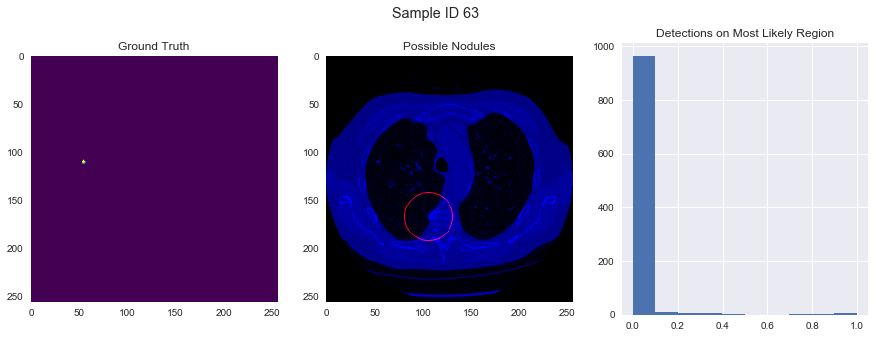

100%|██████████| 1000/1000 [00:13<00:00, 76.48it/s]


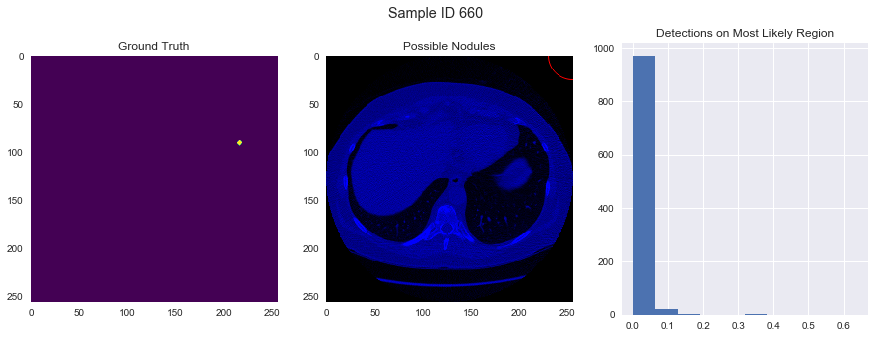

100%|██████████| 1000/1000 [00:13<00:00, 76.79it/s]


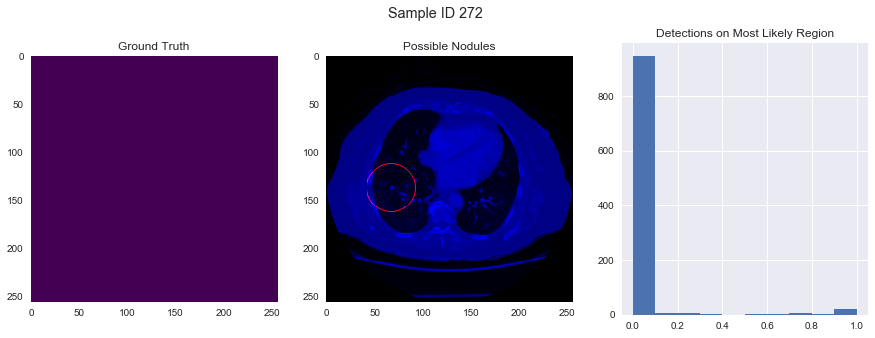

100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


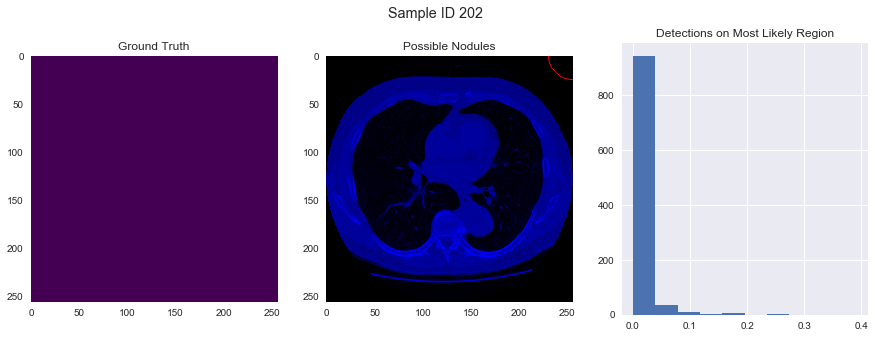

100%|██████████| 1000/1000 [00:13<00:00, 76.22it/s]


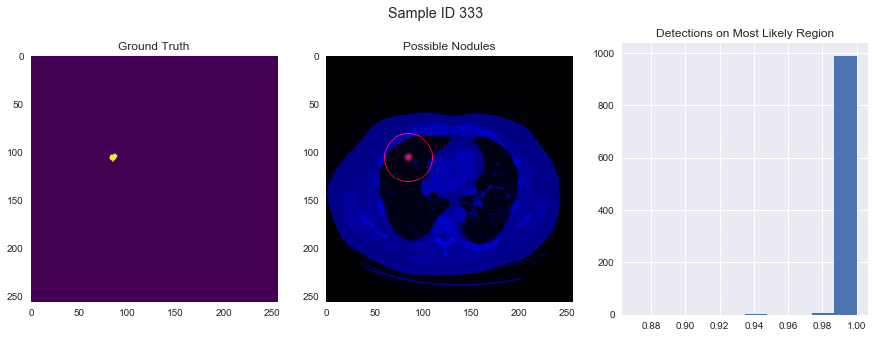

100%|██████████| 1000/1000 [00:13<00:00, 76.57it/s]


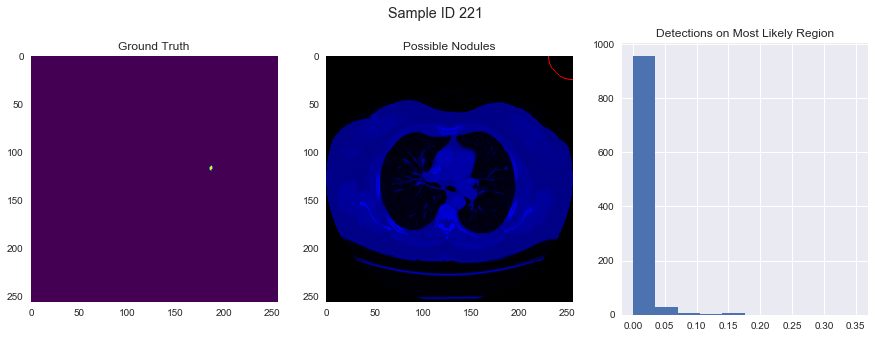

100%|██████████| 1000/1000 [00:13<00:00, 76.55it/s]


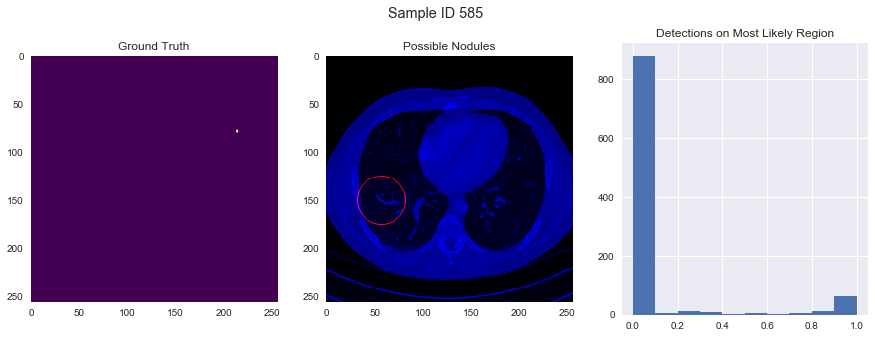

100%|██████████| 1000/1000 [00:13<00:00, 76.51it/s]


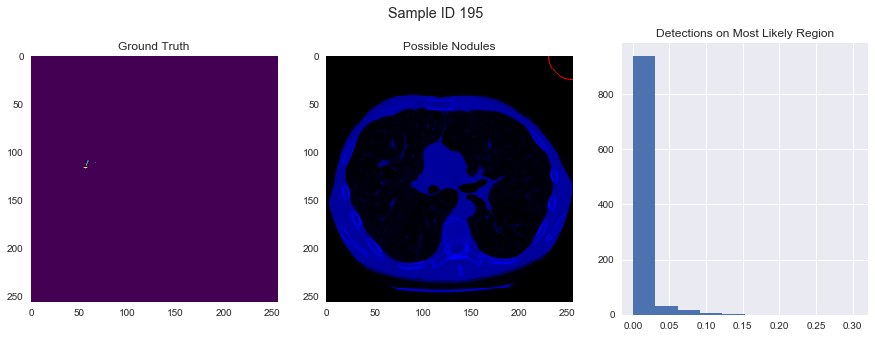

In [73]:
for i in range(30):
    idx = np.random.randint(0, X_train.shape[0])
    evaluate_sample(X_train[idx], Y_train[idx], suptitle='Sample ID {}'.format(idx))